# 数据集创建和整合

我们演示如何使用 `exprmat` 程序包进行单细胞 RNA 测序数据集的读取和整合。其他模态的数据读取步骤是类似的，
只是在元数据的指定上有所不同。单细胞 RNA 测序数据至少需要接受一个表达矩阵，然而，你可以通过非独立模态给其附加
不同剪接状态的表达矩阵（用于 RNA 动力学推断）或淋巴受体谱系追踪的标准 10X 格式 CSV 表，以使用一些与 TCR / BCR
克隆型有关的方法，这里我们演示示例数据集的处理过程

In [1]:
%load_ext autoreload
%autoreload 2

首先，导入程序包并设置工作目录：

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

你可以使用 `em.version` 和 `em.cuda` 这两个实用函数查看当前安装的包版本，注意包版本和数据库版本相对应。
当前的工作目录、配置的数据库目录会打印出来。使用 `em.memory` 可以查看当前实例占用的内存大小。 `em.cuda`
打印了可以使用的 GPU 列表信息

In [3]:
ver = em.version()

[i] exprmat 0.1.47 / exprmat-db 0.1.47
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-rna
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.47)
[i] resident memory: 813.97 MiB
[i] virtual memory: 5.78 GiB


In [4]:
em.cuda()

[i] PyTorch version: 2.8.0+cu128
[i] GPU acceleration availability: YES
[i] CUDA version: 12.8
[i] Number of installed GPUs: 1
[i] Supporting BF16 format: YES
[i] Devices:
[i] [0] NVIDIA GeForce RTX 4090 D *
[i]     CUDA capability: (8, 9)
[i]     Installed VRAM (GiB): 47.38 GiB
[i]     Supporting TensorCore: YES
[i]     Current dedicated memory: 0.00 / 47.38 GiB (0.0%)


### 具有单纯表达矩阵的 scRNA-seq 二级数据

创建元数据，在多数情况下，scRNA-seq 只有二级数据是可用的，我们考虑这个最简单的情形，在元数据表中，
注册了一套来自小鼠骨髓（来自 Cell, Volume 188, Issue 22, 6335 - 6354.e26）的 10X 3' 端单细胞 RNA 测序
这是一个标记实验，小鼠全骨髓细胞未经解离，因此只有造血细胞得到了最大程度保留，除此外没有经过谱系特异性的分选

In [5]:
meta = em.metadata(
    locations    = [
        'src/bm-distal',
        'src/bm-niche',
        'src/bm-normal'
    ],
    modality     = ['rna', 'rna', 'rna'],
    default_taxa = ['mmu', 'mmu', 'mmu'],
    batches      = ['b1', 'b2', 'b3'],
    names        = ['distal', 'niche', 'normal'],
    groups       = ['distal', 'niche', 'normal']
)

我们可以获取元数据表

In [6]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,src/bm-distal,distal,b1,distal,rna,mmu
1,src/bm-niche,niche,b2,niche,rna,mmu
2,src/bm-normal,normal,b3,normal,rna,mmu


当我们确认元数据表没有错误，接下来传入 `em.experiment` 的构造函数中。第一个参数是元数据表，第二个参数告诉程序
将要默认把实验数据集保存的位置

In [8]:
expm = em.experiment(meta, dump = 'expression')

[i] reading sample distal [rna] ...
[i] 286 genes (out of 31053) not in the reference gene list.
[i] total 30767 genes mapped. 30748 unique genes.
[i] reading sample niche [rna] ...
[i] 286 genes (out of 31053) not in the reference gene list.
[i] total 30767 genes mapped. 30748 unique genes.
[i] reading sample normal [rna] ...
[i] 286 genes (out of 31053) not in the reference gene list.
[i] total 30767 genes mapped. 30748 unique genes.


In [10]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  distal   rna   mmu    batch b1      of size 6654 × 30748
  niche    rna   mmu    batch b2      of size 3959 × 30748
  normal   rna   mmu    batch b3      of size 4662 × 30748



### 质量控制

接下来我们对数据及进行质量控制。单细胞 RNA 测序的质量控制的最初步骤是在各个样本中单独进行的。包括排除空液滴、筛选基因表达量过低的细胞、筛选线粒体转录本占比过高的细胞、并推断和去除双胞体。我们通过下面的方法可以对此进行控制。因为各个样本之间是独立的，在每个样本上进行相同的 QC 操作可以并行，我们提供了 `parallel` 参数进行多进程并行，这可以极大的提高处理速度（大约加快 5 倍左右）。然而，对于较少数量的样本，并行不能带来太大的获益，所以我们在这里使用同步的方式

In [11]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'scrublet',
    min_cells = 3,
    min_genes = 300
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 108 ribosomal genes
quality controlling sample [distal] ...
raw dataset contains 6654 cells, 21689 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 2.8 %
[i] estimated detectable doublet fraction: 51.0 %
[i] overall doublet rate: 5.4 %
filtered dataset contains 5787 cells, 18013 genes
[i] found 13 mitochondrial genes (expected 13)
[i] found 107 ribosomal genes
quality controlling sample [niche] ...
raw dataset contains 3959 cells, 21970 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 0.3 %
[i] estimated detectable doublet fraction: 6.3 %
[i] overall doublet rate: 4.6 %
filtered dataset contains 3498 cells, 18089 genes
[i] found 13 mitochondrial genes (expected 13)
[i] found 106 ribosomal g

Here, we will have a glance at the distribution of detected genes per cell.
Typically, this will be a zero-inflated normal distribution. The four marker lines
indicates 0, 100, 300 and 600 genes of the X axis.

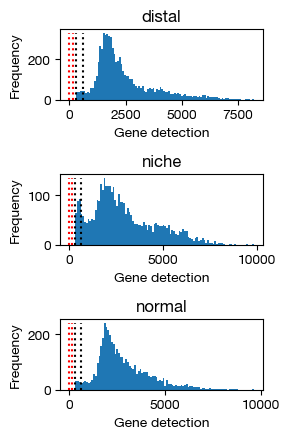

In [12]:
gene_counts = expm.plot_rna_qc_gene_counts(ncols = 1, figsize = (3, 4.5))

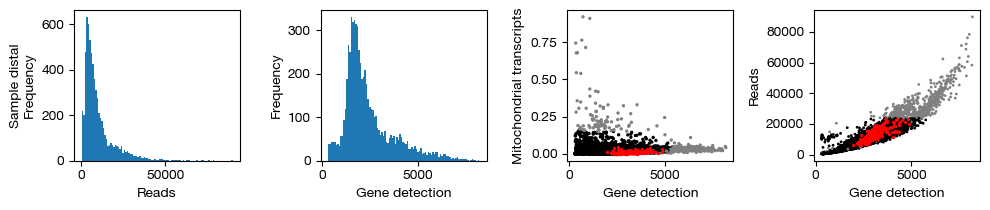

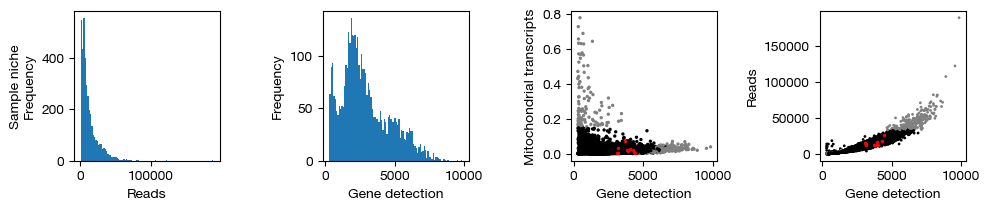

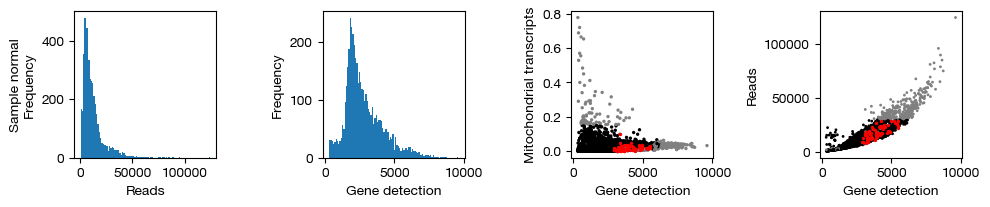

In [13]:
figs = expm.plot_rna_qc(run_on_samples = True)

最后，我们只保留选中的 QC 通过的细胞（上图中黑色的部分，红色部分是推断的双胞体，而灰色则是不符合基因、转录本数、线粒体转录本占比
而被筛除的细胞），这一步操作将永久的从各个样本中删除这些细胞，这个删除是不可逆的。我们不使用 `.raw` 保存未筛选的细胞

In [14]:
expm.save()
expm.run_rna_filter(run_on_samples = True)

[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [rna]           3 / 3     (00:01 < 00:00)


### 分样本处理数据

对于细致的数据处理来说，我们需要先在单个样本水平上观察数据质量，排除异常的样本。

In [15]:
expm.run_rna_log_normalize(
    run_on_samples = True,
    key_norm = 'norm', 
    key_lognorm = 'lognorm'
)

In [16]:
expm.run_rna_select_hvg(
    run_on_samples = True,
    key_lognorm = 'lognorm',
    method = 'vst',
    dest = 'vst',
    n_top_genes = 1500
)

In [17]:
expm.run_rna_scale_pca(
    run_on_samples = True,
    hvg = 'vst.hvg',
    key_lognorm = 'lognorm',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [18]:
expm.run_rna_knn(
    run_on_samples = True,
    use_rep = 'pca',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [19]:
expm.run_rna_leiden(
    run_on_samples = True,
    resolution = 0.5,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

In [20]:
expm.run_rna_umap(
    run_on_samples = True,
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

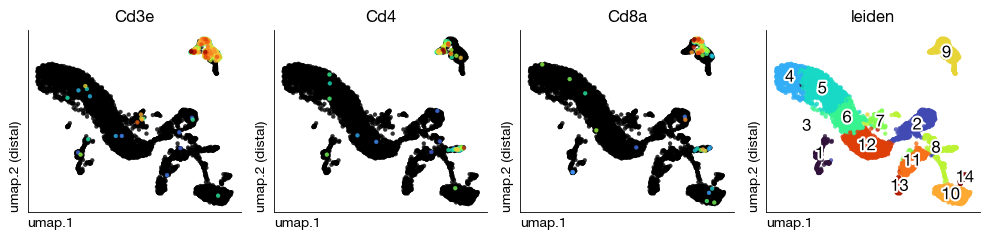

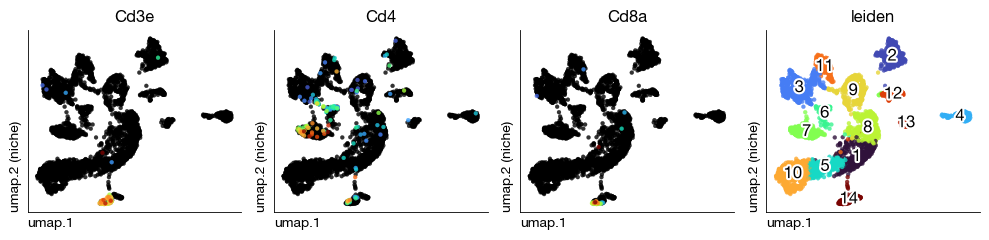

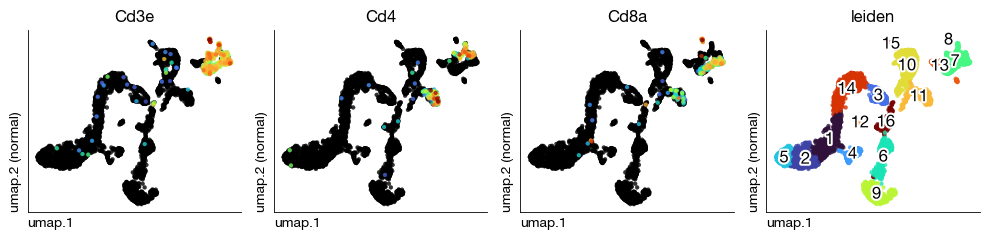

In [22]:
figs = expm.plot_rna_embedding_multiple(
    run_on_samples = True,
    basis = 'umap', features = ['Cd3e', 'Cd4', 'Cd8a', 'leiden'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend = False
)

### 数据集整合

确认每个样本是合理无误之后，对数据进行整合。这将整合所有相同模块的样本，并汇总入一个大的 AnnData 对象中。
`expm.merge` 函数完成这个连接操作，而不改变任何读数。整合数据需要进一步批次校正，得到校正的嵌入表示

In [23]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  distal   rna   mmu    batch b1      of size 5787 × 18013
  niche    rna   mmu    batch b2      of size 3498 × 18089
  normal   rna   mmu    batch b3      of size 4133 × 18384



In [24]:
expm.merge(
    join = 'outer',
    variable_columns = ['vst.hvg'],
    bool_merge_behavior = 'or'
)

In [71]:
expm.run_rna_select_hvg(
    key_lognorm = 'X',
    method = 'vst',
    dest = 'vst.all',
    n_top_genes = 2000,
    batch_key = 'batch',
    sort_hvg_rank_first = False,
    span = 0.3
)

In [72]:
# exclude lateral genes from the highly variable list.
hvgs = expm.mudata['rna'].var['vst.all.hvg'].tolist()
names = expm.mudata['rna'].var['gene'].tolist()
for idx, name in enumerate(names):
    if str(name) == 'nan': continue
    if (name.startswith('Trav') or 
        name.startswith('Trad') or
        name.startswith('Traj') or
        name.startswith('Trac') or
        name.startswith('Trbv') or 
        name.startswith('Trbd') or
        name.startswith('Trbj') or
        name.startswith('Trbc') or
        name.startswith('Rpl') or 
        name.startswith('Rps')
    ):
        hvgs[idx] = False

expm.mudata['rna'].var['vst.all.hvg'] = hvgs
expm.mudata['rna'].var['vst.all.hvg'].value_counts()

vst.all.hvg
False    17708
True      1957
Name: count, dtype: int64

In [73]:
expm.run_rna_scale_pca(
    hvg = 'vst.hvg',
    key_lognorm = 'X',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [74]:
expm.run_rna_integrate(
    method = 'harmony',
    basis = 'pca',
    dest = 'harmony'
)

2025-12-13 11:07:22,333 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-12-13 11:07:23,444 - harmonypy - INFO - sklearn.KMeans initialization complete.


In [79]:
expm.run_rna_knn(
    use_rep = 'harmony',
    n_comps = None,
    n_neighbors = 100,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [76]:
expm.run_rna_leiden(
    resolution = 0.8,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

In [83]:
expm.run_rna_umap(
    min_dist = 0.35,
    spread = 0.9,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

我们可以在整合的 UMAP 中可视化数据集的特征

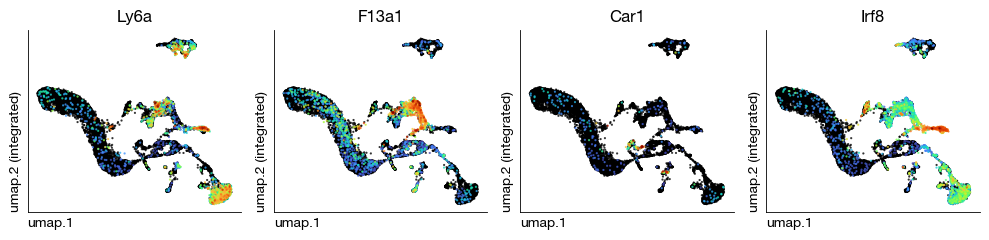

In [90]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Ly6a', 'F13a1', 'Car1', 'Irf8'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend = False, 
    annotate_style = 'text', annotate_fontsize = 8, ptsize = 2
)

In [42]:
print(expm)

annotated data of size 13418 × 19665
integrated dataset of size 13418 × 19665
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o> vst.hvg <bool>
 layers : counts <f32>
   obsm : pca <arr:f64(35)> harmony <arr:f64(35)> knn <arr:i32(30)> knn.d <arr:f64(30)>
          umap <arr:f32(2)>
   varm : pca <arr:f64(35)>
   obsp : connectivities <csr:f32> distances <csr:f64>
    uns : pca neighbors leiden umap leiden.colors

[*] composed of samples:
  distal   rna   mmu    batch b1      of size 5787 × 18013
  niche    rna   mmu    batch b2      of size 3498 × 18089
  normal   r

### 使用 scVI 整合数据集

当不同样本中，细胞类型分布及其不均衡时，基于 MNN 或者 Harmony 的整合方法会倾向于将不同的细胞类型
人为的整合在一起，这会导致无法解释的数据，scVI 方法可以更好的解决这个问题，尤其是你需要将不同分选方案
下进行的测序整合成一个相对无偏的数据集时

In [ ]:
expm.run_rna_scvi(
    batch = 'batch', n_comps = 30, 
    hvg = 'vst.hvg', key_counts = 'counts',
    key_added = 'scvi',

    # seeding options, if you have a semi-annotated data
    seeding = False,
    imputed_label_key = None,

    # parameters passed to scvi
    n_hidden = 128,
    n_layers = 3,
    dropout_rate = 0.1,
    dispersion = "gene",
    gene_likelihood = "zinb",
    use_observed_lib_size = True,
    latent_distribution = "normal",
    max_epochs = None,
)

In [57]:
expm.run_rna_knn(
    use_rep = 'scvi',
    n_comps = None,
    n_neighbors = 50,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'nn.scvi'
)

In [69]:
expm.run_rna_umap(
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 80,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "nn.scvi"
)

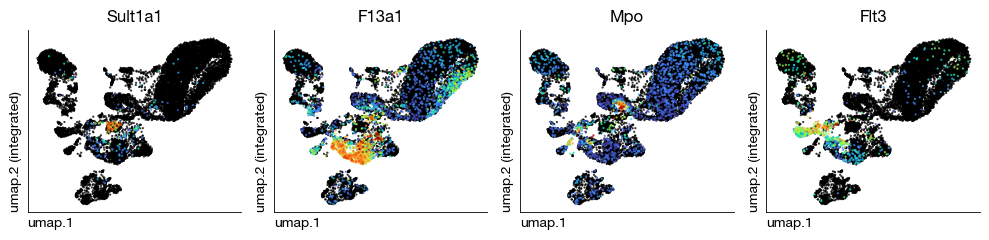

In [70]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Sult1a1', 'F13a1', 'Mpo', 'Flt3'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend = False, 
    annotate_style = 'text', annotate_fontsize = 8, ptsize = 2
)

In [91]:
print(expm)

annotated data of size 13418 × 19665
integrated dataset of size 13418 × 19665
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32>
   obsm : pca <arr:f64(35)> harmony <arr:f64(35)> knn <arr:i32(100)> knn.d <arr:f32(100)>
          umap <arr:f32(2)> scvi <arr:f32(30)> knn.nn.scvi <arr:i32(50)> knn.d.nn.scvi <arr:f32(50)>
   varm : pca <arr:f64(35)>
   obsp : connectivities <csr:f32> distances <csr:f32> connectivities.n

### 保存数据集

保存数据集，如果指定 `save_samples` 参数为 False，我们将不保存样本的分数据集，而只保存整合后的数据。
这可以节省许多时间，或者当你不想让某些新的修改覆盖掉之前已经保存的样本。但是，我们建议你至少保存一个版本的样本数据，
它们在之后可能有用，而且可以避免重复的 QC 操作。

In [92]:
expm.save(save_samples = False)

[i] main dataset write to expression/integrated.h5mu


In [93]:
em.memory()

[i] resident memory: 4.59 GiB
[i] virtual memory: 88.68 GiB
